In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import sklearn.model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
#import dataset and look at column names
shot_orig = pd.read_csv('shot_logs.csv')
shot_orig.shape

(128069, 21)

In [3]:
shot_orig.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'player_name', 'player_id'],
      dtype='object')

In [4]:
# Get rid of game_id as it will not contribute my final model

# Get rid of win and final_margin as they are only known after a game is over,
# and I am trying to model shots taken during a game, so they would not contribute to my final.  

# Get rid of player_name, player_id, closest_defender, closest_defender_player_id,matchup, location because
# these are NBA specific, and I would like to generalize to all basketball games.

pre_shot = shot_orig.loc[: , ['SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
                     'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSE_DEF_DIST', 'PTS']]
pre_shot.head()

,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,PTS
0,1,1,1:09,10.8,2,1.9,7.7,2,made,1.3,2
1,2,1,0:14,3.4,0,0.8,28.2,3,missed,6.1,0
2,3,1,0:00,NaN,3,2.7,10.1,2,missed,0.9,0
3,4,2,11:47,10.3,2,1.9,17.2,2,missed,3.4,0
4,5,2,10:34,10.9,2,2.7,3.7,2,missed,1.1,0


In [5]:
# find if game_clock refers to the time left in the whole game, or just the period
#pre_shot.GAME_CLOCK

# it seems that none of the time goes above 12, so game_clock refers to just the period

Creating a table based off of shot.dtypes:

| Data Column     | Type        |
| ------------- |:-------------:|
|SHOT_NUMBER   | int64 |
| PERIOD    | int64     |
| GAME_CLOCK | object     |
| SHOT_CLOCK| float64      |
| DRIBBLES | int64      |
| TOUCH_TIME |float64     |
| SHOT_DIST| float64     |
| PTS_TYPE| int64   |
| SHOT_RESULT | object    |
| CLOSE_DEF_DIST| float64     |
| PTS | int64    |

Everything is numeric except for GAME_CLOCK and SHOT_RESULT

In [6]:
# convert game_clock to float
#first replace the colon with a period
pre_shot.GAME_CLOCK = pre_shot.GAME_CLOCK.str.replace(':', '.', regex=True)

#convert game_clock into float
pre_shot.GAME_CLOCK = pre_shot.GAME_CLOCK.astype('float')
type(pre_shot.GAME_CLOCK[1])


numpy.float64

In [7]:
#convert shot_result to bool. 1 if made, 0 if missed
pre_shot.SHOT_RESULT = pre_shot.SHOT_RESULT == 'made'

In [8]:
pre_shot.describe(include = 'all')

,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,PTS
count,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069,128069.000000,128069.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70164,NaN,NaN
mean,6.506899,2.469427,5.663617,12.453344,2.023355,2.765901,13.571504,2.264670,NaN,4.123015,0.997314
std,4.713260,1.139919,3.451461,5.763265,3.477760,3.043682,8.888964,0.441159,NaN,2.756446,1.130978
min,1.000000,1.000000,0.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,NaN,0.000000,0.000000
25%,3.000000,1.000000,2.520000,8.200000,0.000000,0.900000,4.700000,2.000000,NaN,2.300000,0.000000
50%,5.000000,2.000000,5.520000,12.300000,1.000000,1.600000,13.700000,2.000000,NaN,3.700000,0.000000
75%,9.000000,3.000000,8.510000,16.675000,2.000000,3.700000,22.500000,3.000000,NaN,5.300000,2.000000


Curiously enough, there seems to be a minimum touch time of -163.6, which would clearly be a mistake in the data, as it is impossibe for touch time to be in the negatives.  Some further exploration is required.

In [9]:
len(pre_shot[pre_shot.TOUCH_TIME < 0])

312

Even with only 312 values of touch_time under 0, I decided against deleting all rows were touch time is under 0.  Instead, I will hold onto these values a bit longer and fix them later.

Before further analysis, I will make sure that the distances for 3 point shots and 2 point shots are accurate.  Given how the minimum distance from the hoop to the 3 point line is 22 feet, and the maximum is 23.75, there should ideally be no distances over 23.75 feet for 2 point shots and no distances under 22 feet for 3 point shots.  It is entirely possible, however, that sometimes a player may jump from behind the line and shoot in front of the line, which would decrease the shot distance, but still be a valid 3 point shot.  Therefore, I will set a cutoff at 19 feet for 3 point shots, meaning all distances under 19 feet will be incorrectly labeled as a 3 point shot.

With 2 point shots, it is also possible for players to jump from in front of the 3 point line and shoot the ball behind the line, but that distance should not be nearly as big as jumping forward from behind the line, so I will set a cutoff of 2 point shots at 25, where all distances above 25 feet will be incorrectly labeled as a 2 point shot.

In [10]:
#create a data frame for just 2 point shots and another for just 3 point shots

pre_shot2 = pre_shot[pre_shot['PTS_TYPE'] == 2]
pre_shot3 = pre_shot[pre_shot['PTS_TYPE'] == 3]

# data frame for incorrect distances
pre_incorrect2 = pre_shot2[pre_shot2['SHOT_DIST'] > 25]
pre_incorrect3 = pre_shot3[pre_shot3['SHOT_DIST'] < 19]
print("Number of incorrectly labeled 2 point shots is", len(pre_incorrect2))
print("Number of incorrectly labeled 3 point shots is", len(pre_incorrect3))

Number of incorrectly labeled 2 point shots is 112
Number of incorrectly labeled 3 point shots is 88


For a dataset with 128 thousand rows, these 200 observations isn't too bad.  These observations will be dealt with in a bit.

In [11]:
misvals = pd.DataFrame(pd.DataFrame(pre_shot.describe(include = 'all')).iloc[0, :])
misvals['percentage of missing values'] = (128069 - misvals['count']) / 128069

Creating a table based off of misvals: 

| Data Column     | percentage of missing values      |
| ------------- |:-------------:|
|SHOT_NUMBER   | 0|
| PERIOD    | 0   |
| GAME_CLOCK | 0    |
| SHOT_CLOCK|0.0434688  |
| DRIBBLES | 0    |
| TOUCH_TIME |0   |
| SHOT_DIST| 0   |
| PTS_TYPE| 0   |
| SHOT_RESULT | 0  |
| CLOSE_DEF_DIST|0   |
| PTS |0   |


It seems that all columns except for shot_clock have the full 128069 values.  Shot_clock is only missing less than 5% of its values, so dropping the column would not be considered.

At this point, it seems that there are 3 columns that need cleaning: shot_clock is missing values, touch_time has some nonsensical values, and the pts_type do not completely align with all the shot_dist.  I will proceed by dropping all rows containing 2 or all of these errors.  I chose to do so with only 2 or more errors because, with that many errors, the observation becomes too unreliable.  However, for an observation with only 1 error, I would only need to make adjustments to one variable, which will lead to a less bias in the final model compared to adjustments to multiple variables.

In [12]:
# make array that returns true if there is a discrepancy
pre_discrep2 = (pre_shot.PTS_TYPE == 2) & (pre_shot.SHOT_DIST > 25)
pre_discrep3 = (pre_shot.PTS_TYPE == 3) & (pre_shot.SHOT_DIST < 19)
x = pre_discrep2 | pre_discrep3
print(sum(x), 'observations that have discrepancy in shot distance ')

#array that returns true if there is a missing shot clock value
y = (pre_shot.SHOT_CLOCK != pre_shot.SHOT_CLOCK)
print(sum(y), 'observations that have a missing shot clock value')

# array that returns true if touch time is less than 0
z = (pre_shot.TOUCH_TIME < 0)
print(sum(z), 'observations have negative touch times')

print(sum(x & y), 'observations have a discrepancy in shot distance and a missing shot clock')
print(sum(x & z), 'observations have a discrepancy in shot distance and a negative touch time')
print(sum(y & z), 'observations have a missing shot clock and a negative touch time')
print(sum(x & y & z), 'observations have all three errors')

200 observations that have discrepancy in shot distance 
5567 observations that have a missing shot clock value
312 observations have negative touch times
60 observations have a discrepancy in shot distance and a missing shot clock
7 observations have a discrepancy in shot distance and a negative touch time
13 observations have a missing shot clock and a negative touch time
0 observations have all three errors


Because no observations have all 3 errors, we can add up the last 4 sums to get 80, meaning we should filter out, in total, 80 observations from the original dataset.

In [13]:
# filtering for observations with 2 or more of these errors
xyz = (x & y) | (x & z) | (y & z) | (x & y & z)
print(sum(xyz), 'observations are have 2 or more of these errors')

#make an array that returns false if the observation has 2 or more of these errors
filt = [not i for i in xyz]
shot = pre_shot[filt]

#make sure that the new data frame length plus the filtered out observations equals the original data frame length
len(shot) + sum(xyz) == len(pre_shot)

80 observations are have 2 or more of these errors


True

After dropping all of these observations, I will now fix the observations that contain only one of these errors.

In [14]:
# I will change the negative touch_time values to 0, as that is the minimum
# amount of time that a player can hold the ball.

shot.TOUCH_TIME[shot.TOUCH_TIME < 0] = 0

/Users/ray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/ray/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:7620: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/ray/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.us

In [15]:
# find out how many NaN are in shot_clock for the filtered data frame
print(sum(shot.SHOT_CLOCK.isna()), 'observations have missing shot_value, which is', 
          sum(shot.SHOT_CLOCK.isna()) / len(shot.SHOT_CLOCK) * 100, '% of number of observations')

5494 observations have missing shot_value, which is 4.2925563915649 % of number of observations


With only less than 5% of data missing, I will impute the missing data with the mean, as doing so will not contribute to too much bias in the final model.

In [16]:
#fill the NaN in shot_clock with the mean.  
shot[['SHOT_CLOCK']] = shot[['SHOT_CLOCK']].fillna(shot[['SHOT_CLOCK']].mean())

/Users/ray/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


For the observations with discrepancies between the shot distance and the points type, it is unclear whether the discrepancy comes from a mistake in points type, or if it comes from a mistake in shot distance.  I decided to change the points type to match to the shot distance because, given a shot distance in a certain range, you can find out exactly how many points the shot is worth (unless the distance is between 22 and 23.75, but those observations were not counted as errors).

In [23]:
#create filters for pts_type incorrectly labelled as 2 and 3
discrep2 = (shot.PTS_TYPE == 2) & (shot.SHOT_DIST > 25)
discrep3 = (shot.PTS_TYPE == 3) & (shot.SHOT_DIST < 19)

#use filters to change the pts_type to the correct value
shot.loc[discrep2, 'PTS_TYPE'] = 3
shot.loc[discrep3, 'PTS_TYPE'] = 2

/Users/ray/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [25]:
# Check to make sure the labels were changed

#create a data frame for just 2 point shots and another for just 3 point shots for filtered dataframe
shot2 = shot[shot['PTS_TYPE'] == 2]
shot3 = shot[shot['PTS_TYPE'] == 3]

# data frame for incorrect distances
incorrect2 = shot2[shot2['SHOT_DIST'] > 25]
incorrect3 = shot3[shot3['SHOT_DIST'] < 19]
print("Number of incorrectly labeled 2 point shots is", len(incorrect2))
print("Number of incorrectly labeled 3 point shots is", len(incorrect3))

Number of incorrectly labeled 2 point shots is 0
Number of incorrectly labeled 3 point shots is 0


Using the cleaned 'shot' data frame, I will use shot_result as my target column and everything else except pts as my input columns.  I am excluding pts as it details the amount of points resulting from the shot, so it would
not be a good predictor of shot_result.  I am keeping the column, however, because I will use pts for future analysis. 

In [26]:
sum(shot.SHOT_RESULT) / len(shot.SHOT_RESULT)

# The shot_result column is boolean, with 1 being if the shot was made, and 0 being if the shot was missed.  It
# seems that about 45% of all total shots are made.

0.45233574760330963

In [27]:
#create data frame where shot was missed and shot was made for some eda
shot_made = shot.loc[shot['SHOT_RESULT'] == 1, :]
shot_missed = shot.loc[shot['SHOT_RESULT'] == 0, :]

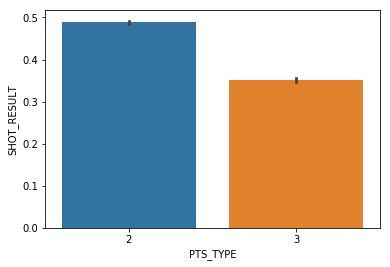

In [28]:
#comparing makes and misses for 2 point shots vs 3 point shots

sns.barplot(x = shot.PTS_TYPE, y = shot.SHOT_RESULT)

#as expected, shots worth 2 points have a much higher percentage (around 49%) than shots worth 3 points (around 35%)

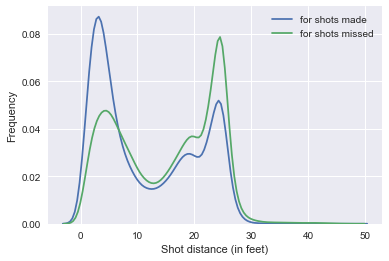

In [29]:
# EDA for a few variables that probably impact probability of shot being made

# two line histograms of shot distances
sns.set()
sns.distplot(shot_made['SHOT_DIST'], hist = False, label = 'for shots made')
sns.distplot(shot_missed['SHOT_DIST'], hist = False, label = 'for shots missed')
plt.ylabel('Frequency')
plt.xlabel('Shot distance (in feet)')
plt.show()

# the two distributions are definitely different, with, as expected, more shots being made the closer the shot
# is taken to the rim.  Of note is the two peaks at the same distance for both line histograms.  The first
# peak represents shots taken close to the rim, meaning probably layups or dunks.  The second peak represents
# the distance for a three point shot.  The little bump in the second peak most likely represents corner three
# point shots, which are closer to the rim than other three point shots.

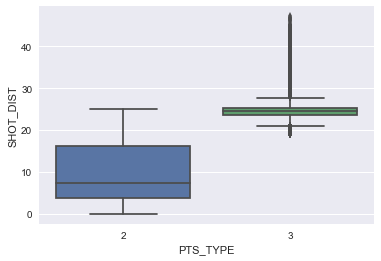

In [30]:
#comparing shot distance and whether or not it was a 3

sns.boxplot(shot['PTS_TYPE'], shot['SHOT_DIST'])
plt.show()

This boxplot shows that there are a few outliers for the 3 point shots, and the interquartile range for 2 point shots is much larger than it is for 3 point shots.

In [33]:
#stacked percentage bar plot for dribbles taken

#create new data frame for just dribbles
#column for total shots taken indexed by dribbles
drib = shot.groupby('DRIBBLES').count()[['SHOT_RESULT']]
drib = drib.rename(columns = {"SHOT_RESULT" : 'total'})

#column for shots made
drib['made'] = shot_made.groupby('DRIBBLES').count()[['SHOT_RESULT']]
#add in column for percentage of shots made
drib['made_percentage'] = drib['made'] / drib['total']

#add in column for shots missed and percentage of shots missed
drib['missed'] = shot_missed.groupby('DRIBBLES').count()[['SHOT_RESULT']]
drib['missed_percentage'] = drib['missed'] / drib['total']

#change nan to 0
drib = drib.fillna(0)

#reset index
drib = drib.reset_index()
drib.head()

,DRIBBLES,total,made,made_percentage,missed,missed_percentage
0,0,63127,29805.0,0.472143,33322,0.527857
1,1,19400,8813.0,0.454278,10587,0.545722
2,2,13859,5883.0,0.424490,7976,0.575510
3,3,7788,3317.0,0.425912,4471,0.574088
4,4,5199,2243.0,0.431429,2956,0.568571


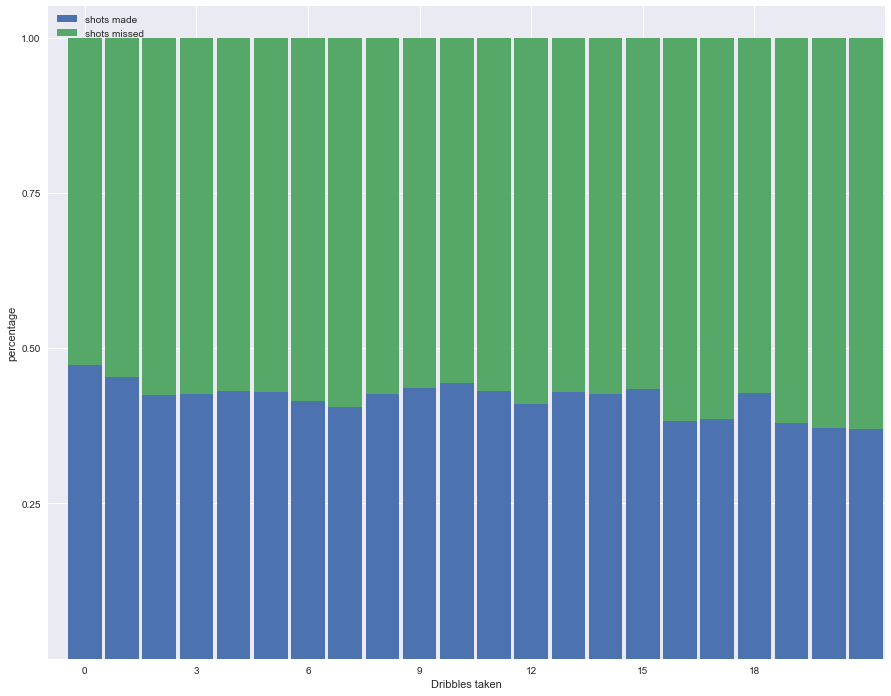

In [34]:
#plot the dribbles as a percentage stacked bar chart
plt.figure(figsize = (15,12))
plt.bar(drib.DRIBBLES, drib.made_percentage, width = .9, label = "shots made")
plt.bar(drib.DRIBBLES, drib.missed_percentage, width = .9, bottom = drib.made_percentage, label = "shots missed")
plt.xlabel('Dribbles taken')
plt.ylabel('percentage')
plt.yticks([.25, .5, .75, 1])
plt.xticks(np.arange(21, step = 3))
plt.legend(loc = 'upper left')
plt.xlim([-1,21.5])
plt.show()

I chose to use a percentage stacked bar chart so I can try to how the percentages for shots made and missed vary for each dribble taken.  I chose to set the x limits to go up to 21 because, as shown in the data frame with just the dribbles, starting from 22 dribbles and on, there are 100 or less total shots taken for each dribble number.  Therefore, the I decided to leave them out as taking that many dribbles is very uncommon.  As can be shown from the plot, it seems that the more dribbles a player takes, the less likely it becomes for him to make a shot, although this effect is pretty small.  With 18 dribbles, the shot made percentage seems to be a bit high for the trend, and between 8 and 12 dribbles inclusive, there seems to be a little bump in the overall trend of decreasing shot made percentage.  While taking less dribbles does increase shot percentage, it does not seem to be a major factor.

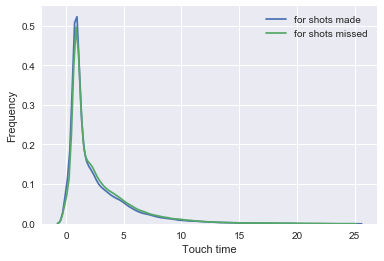

In [35]:
# two line histograms of touch time before the shot

sns.set()
sns.distplot(shot_made['TOUCH_TIME'], hist = False, label = 'for shots made')
sns.distplot(shot_missed['TOUCH_TIME'], hist = False, label = 'for shots missed')
plt.ylabel('Frequency')
plt.xlabel('Touch time')
plt.show()

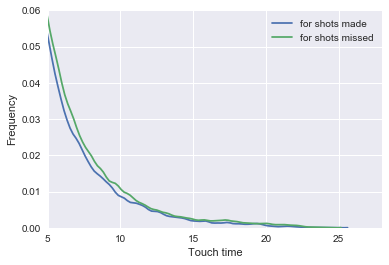

In [36]:
# zoomed in

sns.set()
sns.distplot(shot_made['TOUCH_TIME'], hist = False, label = 'for shots made')
sns.distplot(shot_missed['TOUCH_TIME'], hist = False, label = 'for shots missed')
plt.ylabel('Frequency')
plt.xlabel('Touch time')
plt.xlim(5, 28)
plt.ylim(0, .06)
plt.show()

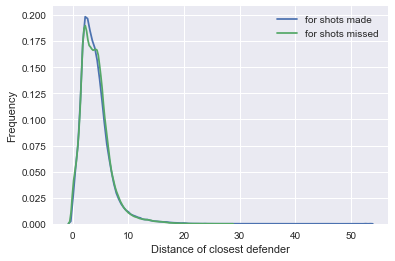

In [37]:
# two line histograms of closest defender
sns.set()
sns.distplot(shot_made['CLOSE_DEF_DIST'], hist = False, label = 'for shots made')
sns.distplot(shot_missed['CLOSE_DEF_DIST'], hist = False, label = 'for shots missed')
plt.ylabel('Frequency')
plt.xlabel('Distance of closest defender')
plt.show()

# Other than the fact that the shots missed has a lower peak, the distribution of close_def_dist for
# shots made and shots missed seem fairly equal .

In [43]:
#modeling

# create and isolate list of shot_results as boolean
shot_y = shot.SHOT_RESULT

#create dataframe of non-object independent variables 
shot_X = shot[['SHOT_NUMBER', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK',
               'SHOT_DIST', 'CLOSE_DEF_DIST', 'PTS_TYPE']]

In [44]:
# split data into training and testing

Xtrain, Xtest, ytrain, ytest = train_test_split(shot_X, shot_y, test_size = .25,
                                               random_state = 99)

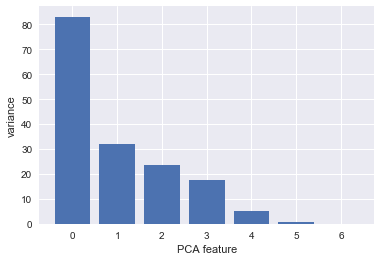

In [46]:
# pca plot to reduce dimensionality

pca = PCA()
pca.fit(Xtrain)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [40]:
# attempt to find the percentage of shot_result for different kinds
# kinds of shots first

# use a logistic regression to classify whether or not shot was made

lr = LogisticRegression()
lr.fit(Xtrain, ytrain)
print(accuracy_score(lr.predict(Xtest), ytest))
print(accuracy_score(lr.predict(Xtrain), ytrain))

# simple model seems to be very inaccurate with training and testing data.
# curiously enough, the two accuracy scores are very similar, and it is
# actually higher for the test data.
# This is probably a due to the fact that basketball shots percentages are
# highly volatile in and of themselves.  Repeated basketball shots, when
# when taken in the exact same context, is still most likely comprised of
# both makes and misses.

0.6084755297206076
0.6090362638163994


In [ ]:
# Fine-tuning the model
#Cs = [0.001, 0.1, 1, 10, 100]

#parameters = {'C' : Cs}
#cgrid = GridSearchCV(lr, param_grid = parameters, cv = 5)
#cgrid.fit(Xtrain, ytrain)
#cgrid.best_estimator_, cgrid.best_params_, cgrid.best_score_, cgrid.grid_scores_